In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import KFold

from datetime import datetime
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
from pymongo import MongoClient
import pymongo
import matplotlib

import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms.functional as TF

import random
import pickle

from PIL import Image

from matplotlib import colors

In [2]:
class LoadMRIDataSet(Dataset):
    '''
    Load our MRI images saved in the MongoDB.
    '''
    
    def __init__(self, db_link = "10.200.205.226:27017", db_name = "aswin_image_segmentation", db_col = "training_data", transform=None):
        self.client = MongoClient(db_link)
        self.db = self.client[db_name]
        self.collection = self.db[db_col]
        self.metadata_csv = pd.read_csv('image_name_info_apr_20.csv') # .sample(frac = 1).reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return self.metadata_csv.count()[0]
    
    def __getitem__(self, idx):

        query_val = self.metadata_csv.iloc[idx, 0]
        data_from_db = self.collection.find_one({"img_name" : query_val})
        data = {
            "image" : np.array(data_from_db['image']),
            "label" : np.array(data_from_db['label'])
        }
        
        if self.transform:
            data = self.transform(data)
        
        data['image'] = Image.fromarray(np.uint8(data['image']*255))
        
        data['label'] = Image.fromarray(np.uint8(data['label']))
        
        # Random horizontal flipping
        if random.random() > 0.5:
            data['image'] = TF.hflip(data['image'])
            data['label'] = TF.hflip(data['label'])

        # Random vertical flipping
        if random.random() > 0.5:
            data['image'] = TF.vflip(data['image'])
            data['label'] = TF.vflip(data['label'])
            
        # Random vertical flipping
        if random.random() > 0.5:
            data['image'] = TF.rotate(data['image'], 90)
            data['label'] = TF.rotate(data['label'], 90)
        
        data['image'] = TF.to_tensor(data['image'])
        data['label'] = torch.from_numpy(np.array(data['label']))
#         data['label'] = data['label'].view(data['label'].shape[1], data['label'].shape[2])
        
#         print(data['label'].max())
#         return data['image'], data['label']
        return data

In [3]:
class Normalize_Image(object):
    '''
    Normalize images across each sequence and slice.
    That is, image (HxWxc) -> Normalization happens for each channel.
    '''

    def __call__(self, data):
        image, label = data['image'], data['label']
        
        min_val = image.min((0,1))
        max_val = image.max((0,1))
        
        image = (image - min_val)/(max_val - min_val)
        
#         print(min_val, max_val)
        
        return {'image': image,
                'label': label}

In [4]:
class Standardize_Image(object):
    '''
    Normalize images across each sequence and slice.
    That is, image (HxWxc) -> Normalization happens for each channel.
    '''

    def __call__(self, data):
        image, label = data['image'], data['label']
        
        mean = image.mean((0,1))
        std = image.std((0,1))
        
        if (std != 0).all():
            image = (image - mean)/std
        
#         print(min_val, max_val)
        
        return {'image': image,
                'label': label}

## Model Building

# Depth of network = 4

In [5]:
def cont_conv_block(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, 3, padding=1),
        nn.ReLU(inplace=True)
                        )

def cont_conv(in_channel, path_depth):
    contractive_layers = nn.ModuleList()
    contractive_layers.append(cont_conv_block(in_channel, 64))
    contractive_layers.append(nn.MaxPool2d(2, stride=2))
    in_channel = 64
    for i in range(1, path_depth):
        contractive_layers.append(cont_conv_block((2**(i-1))*in_channel, (2**(i))*in_channel))
        contractive_layers.append(nn.MaxPool2d(2, stride=2))
        
    return contractive_layers[:-1]

def exp_conv(path_depth):
    expansive_layers = nn.ModuleList()
    in_channel = 256
    for i in range(1, path_depth):
#         print(in_channel, i, int(2**-(i-1)*in_channel), int(2**-(i)*in_channel))
        expansive_layers.append(nn.ConvTranspose2d(int(2**-(i-1)*in_channel), int(2**-(i)*in_channel), 2, 2))
        expansive_layers.append(cont_conv_block(int(2**-(i-1)*in_channel), int(2**-(i)*in_channel)))
        
    return expansive_layers

class MRI_UNet(nn.Module):
    def __init__(self):
        super(MRI_UNet, self).__init__()
        self.cont_path = cont_conv(4,3)
        self.exp_path = exp_conv(3)
        self.last_layer = nn.Conv2d(64, 5, 1) # 5 output layers instead of 4
                                              # This is because I differentiated 
                                              # the background and the brain without any tumour
        
    def forward(self, inp_image):
        # Contractive path / down path
#         print('inp: ',inp_image.shape)
        d1 = self.cont_path[0](inp_image)
#         print('d1: ',d1.shape)
        dm1 = self.cont_path[1](d1)
#         print('dm1: ',dm1.shape)
        d2 = self.cont_path[2](dm1)
#         print('d2: ',d2.shape)
        dm2 = self.cont_path[3](d2)
#         print('dm2: ',dm2.shape)
        d3 = self.cont_path[4](dm2)
#         print(d2.shape)

        # Expansive path / up path
        u1 = self.exp_path[0](d3)
#         print('u1: ',u1.shape)
#         u1 = self.exp_path[1](torch.cat([cropped_feature(d2, u1), u1], 1))
        u1 = self.exp_path[1](torch.cat([d2, u1], 1))
#         print('u1_after_cat: ',u1.shape)
        u2 = self.exp_path[2](u1)
#         print('u2: ',u2.shape)
#         u2 = self.exp_path[3](torch.cat([cropped_feature(d1, u2), u2], 1))
        u2 = self.exp_path[3](torch.cat([d1, u2], 1))
#         print('u2_after_cat: ',u2.shape)

        # Last layer with 1x1 convolution
        out = self.last_layer(u2)
        
        return out        
        

In [6]:
model = MRI_UNet()

In [7]:
print(model)

MRI_UNet(
  (cont_path): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (exp_path): ModuleList(
    (0): ConvTranspose2d(256, 128, k

In [8]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        self.weights = weight

    def forward(self, inputs, targets, eps=0.001):

        inputs = torch.argmax(F.log_softmax(inputs, dim=1), dim=1)
        
        inputs = F.one_hot(inputs, 5).float()
        targets = F.one_hot(targets.long(), 5).float()
        
        bat_sz = inputs.shape[0]
        ch_sz = inputs.shape[3]
        
        intersection = (inputs.view(bat_sz,-1,ch_sz) * targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print("intersection: ",intersection)

        total = (inputs.view(bat_sz,-1,ch_sz) + targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print(total)

        union = total - intersection
#         print(union)

        IoU = (intersection + eps)/(union + eps)
#         print(IoU)

        iouLoss = 1 - (IoU.mean(0) * self.weights).sum()/self.weights.sum()

        return iouLoss, IoU.mean(0)

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        self.weights = weight

    def forward(self, inputs, targets, eps=0.001):
        
        inputs = torch.argmax(F.log_softmax(inputs, dim=1), dim=1)
        
        inputs = F.one_hot(inputs, 5).float()
        targets = F.one_hot(targets, 5).float()
        
        bat_sz = inputs.shape[0]
        ch_sz = inputs.shape[3]

        intersection = (inputs.view(bat_sz,-1,ch_sz) * targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print("intersection: ",intersection)

        total = (inputs.view(bat_sz,-1,ch_sz) + targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print(total)

        dice = (2 * intersection + eps)/(total + eps)
#         print(IoU)

        diceLoss = 1 - (dice.mean(0) * self.weights).sum()/self.weights.sum()

        return diceLoss, dice.mean(0)

# Testing

In [32]:
test_model1 = torch.load('models/U-net-arch1.pth', map_location=torch.device('cuda'))

In [33]:
test_model2 = torch.load('models/U-net-arch2.pth', map_location=torch.device('cuda'))

In [34]:
data_name = pd.read_csv('image_name_info.csv')
dataset = LoadMRIDataSet(transform=transforms.Compose([Normalize_Image()]))

N_SPLITS = 5

nfold = KFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(nfold.split(data_name)):
#     log_dict = dict()

    print("Fold: ", fold+1, "/", N_SPLITS) #, train_ids.shape, test_ids.shape)

    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    testloader = DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)
    
    break

Fold:  1 / 5


In [35]:
device = "cuda"

In [36]:
len(testloader)

1066

In [43]:
loss_weights1 = torch.FloatTensor([0.1, 0.1, 0.5, 0.5, 0.5]).to(device)
# loss_weights = torch.FloatTensor([1,1,1,1,1]).to(device)

seg_loss1 = nn.CrossEntropyLoss(weight=loss_weights1).to(device)
iou_loss1 = IoULoss(weight=loss_weights1).to(device)
dice_loss1 = DiceLoss(weight=loss_weights1).to(device)

In [44]:
loss_weights2 = torch.FloatTensor([1,1,1,1,1]).to(device)
# loss_weights = torch.FloatTensor([1,1,1,1,1]).to(device)

seg_loss2 = nn.CrossEntropyLoss(weight=loss_weights2).to(device)
iou_loss2 = IoULoss(weight=loss_weights2).to(device)
dice_loss2 = DiceLoss(weight=loss_weights2).to(device)

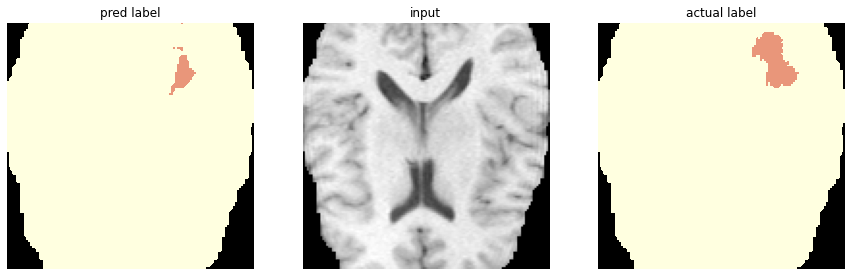

Accuracy: 0.98


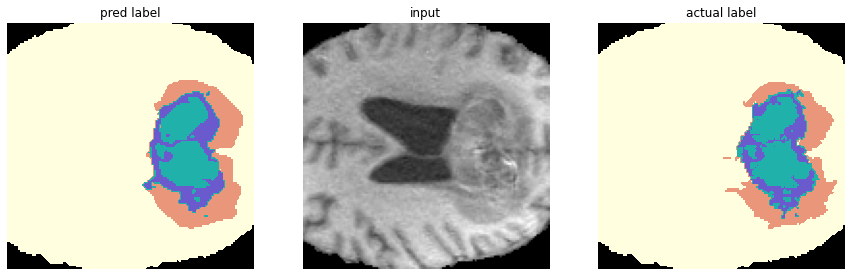

Accuracy: 0.97


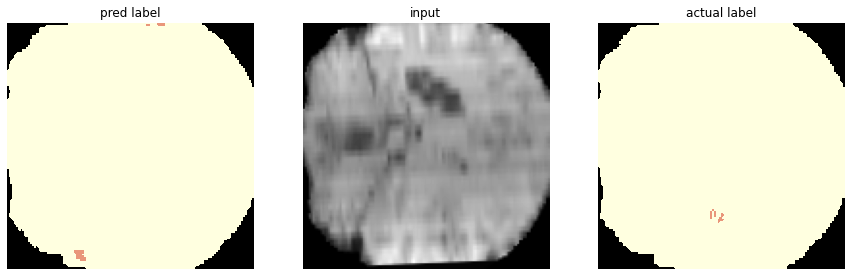

Accuracy: 0.99


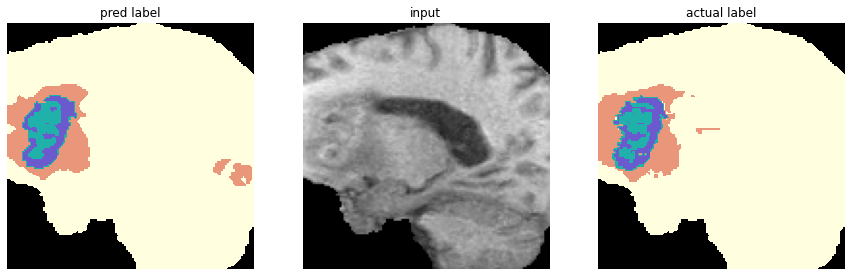

Accuracy: 0.97


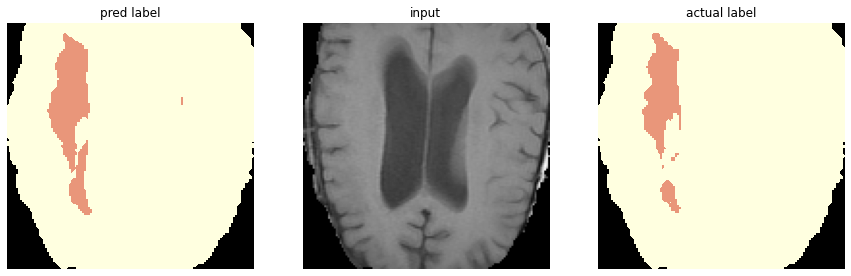

Accuracy: 0.98


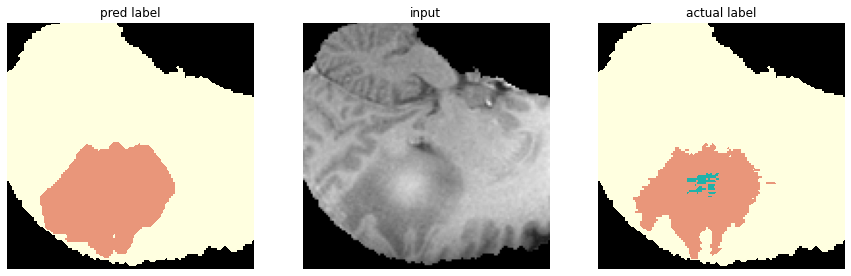

Accuracy: 0.96


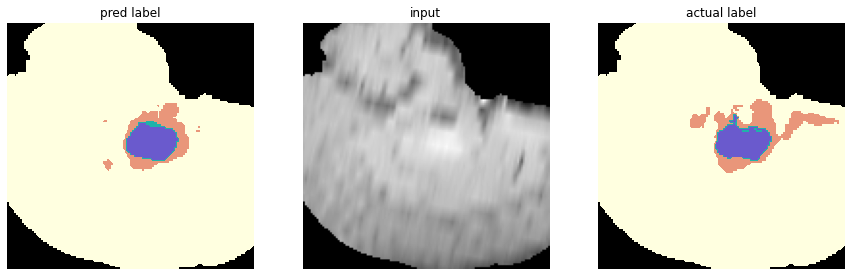

Accuracy: 0.97


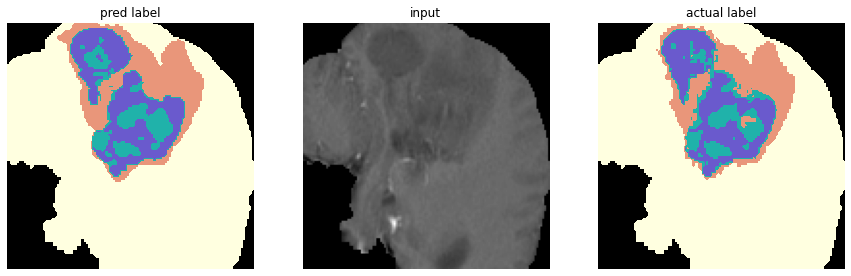

Accuracy: 0.95


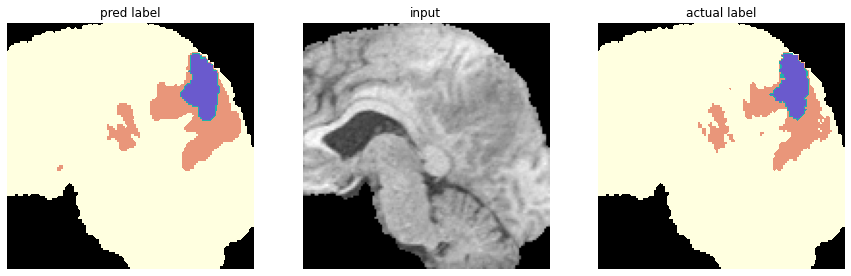

Accuracy: 0.98


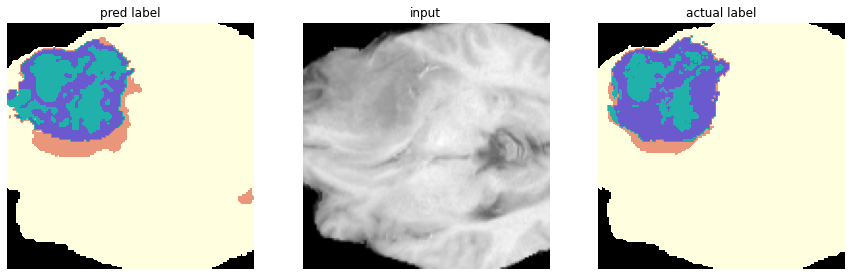

Accuracy: 0.94


In [75]:
# results = list()
for j, test_data in enumerate(testloader, 0):
    plt.figure(figsize=(15,20))
#     log_dict = dict()

    test_inputs, test_labels = test_data['image'], test_data['label']

    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    predictions = test_model(test_inputs.float()).to(device)
    
    
    lossCE = seg_loss(predictions.float(), test_labels.long())

    lossIoU, IoU_per_ch = iou_loss(predictions.float(), test_labels.long())

    diceLoss, dice_per_ch = dice_loss(predictions.float(), test_labels.long())

    clr = ['black','lightyellow', 'darksalmon', 'lightseagreen', 'slateblue']
    cmap = colors.ListedColormap(clr)
    plt.subplot(1,3,1)
    plt.imshow(torch.argmax(F.log_softmax(predictions[0], dim=0), dim=0).cpu(), cmap=cmap, vmin=-1, vmax=5)
    plt.title('pred label')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(test_inputs[0, 1].cpu(), cmap='gray')
    plt.title('input')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(test_labels[0].cpu(), cmap=cmap, vmin=-1, vmax=5)
    plt.title('actual label')
    plt.axis('off')
    
    plt.savefig('boxplots/' + str(j) + '.jpg', dpi=300)
    plt.show()
    
    pred = torch.argmax(F.log_softmax(predictions[0], dim=0), dim=0).cpu()
    act = test_labels[0].cpu()
    acc = (pred==act).sum()/torch.numel(act)
    
    print("Accuracy: {:.2f}".format(acc.item()))
    
    if (j+1)%10 == 0:
        break

In [57]:
results = list()
for j, test_data in enumerate(testloader, 0):

    test_inputs, test_labels = test_data['image'], test_data['label']

    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    predictions1 = test_model1(test_inputs.float()).to(device)
    predictions2 = test_model2(test_inputs.float()).to(device)
    
    
    lossCE1 = seg_loss1(predictions1.float(), test_labels.long())

    lossIoU1, IoU_per_ch1 = iou_loss1(predictions1.float(), test_labels.long())

    diceLoss1, dice_per_ch1 = dice_loss1(predictions1.float(), test_labels.long())
    
    lossCE2 = seg_loss2(predictions2.float(), test_labels.long())

    lossIoU2, IoU_per_ch2 = iou_loss2(predictions2.float(), test_labels.long())

    diceLoss2, dice_per_ch2 = dice_loss2(predictions2.float(), test_labels.long())
    
    pred1 = torch.argmax(F.log_softmax(predictions1[0], dim=0), dim=0).cpu()
    act1 = test_labels[0].cpu()
    acc1 = (pred1==act1).sum()/torch.numel(act1)
    
    pred2 = torch.argmax(F.log_softmax(predictions2[0], dim=0), dim=0).cpu()
    act2 = test_labels[0].cpu()
    acc2 = (pred2==act2).sum()/torch.numel(act2)
    
#     print("Accuracy: {:.2f}".format(acc.item()))
    
    result_dict_arch_1 = dict({
        "cross entropy loss" : lossCE1.item(),
        "IoU loss" : lossIoU1.item(),
        "Dice loss" : diceLoss1.item(),
        "brain background dice" : dice_per_ch1[1].item(),
        "brain background IoU" : IoU_per_ch1[1].item(),
        "Edema dice" : dice_per_ch1[2].item(),
        "Edema IoU" : IoU_per_ch1[2].item(),
        "NET dice" : dice_per_ch1[3].item(),
        "NET IoU" : IoU_per_ch1[3].item(),
        "ET dice" : dice_per_ch1[4].item(),
        "ET IoU" : IoU_per_ch1[4].item(),
        "accuracy" : acc1.item(),
        "architecture": "architecture 1",
        "index" : j
    })
    
    results.append(result_dict_arch_1)
    
    result_dict_arch_2 = dict({
        "cross entropy loss" : lossCE2.item(),
        "IoU loss" : lossIoU2.item(),
        "Dice loss" : diceLoss2.item(),
        "brain background dice" : dice_per_ch2[1].item(),
        "brain background IoU" : IoU_per_ch2[1].item(),
        "Edema dice" : dice_per_ch2[2].item(),
        "Edema IoU" : IoU_per_ch2[2].item(),
        "NET dice" : dice_per_ch2[3].item(),
        "NET IoU" : IoU_per_ch2[3].item(),
        "ET dice" : dice_per_ch2[4].item(),
        "ET IoU" : IoU_per_ch2[4].item(),
        "accuracy" : acc2.item(),
        "architecture": "architecture 2",
        "index" : j
    })
    
    results.append(result_dict_arch_2)

In [58]:
results_df = pd.DataFrame(results)

In [59]:
results_df

,cross entropy loss,IoU loss,Dice loss,brain background dice,brain background IoU,Edema dice,Edema IoU,NET dice,NET IoU,ET dice,ET IoU,accuracy,architecture,index
0,0.342866,0.718641,0.670790,0.964414,0.931275,0.726459,0.570425,2.652513e-06,2.652513e-06,0.000003,0.000003,0.914917,architecture 1,0
1,0.180776,0.473237,0.441435,0.952194,0.908750,0.840611,0.725047,1.086945e-05,1.086945e-05,0.000008,0.000008,0.935608,architecture 2,0
2,0.734044,0.706833,0.634875,0.986262,0.972897,0.675652,0.510177,6.934808e-07,6.934808e-07,0.168519,0.092013,0.869141,architecture 1,1
3,0.386036,0.518202,0.464009,0.971902,0.945340,0.545892,0.375414,7.007704e-07,7.007704e-07,0.162163,0.088236,0.843994,architecture 2,1
4,0.161968,0.342917,0.236206,0.990020,0.980237,0.857346,0.750311,4.589060e-01,2.977809e-01,0.882645,0.789941,0.972778,architecture 1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,0.084426,0.284859,0.190782,0.985918,0.972227,0.834427,0.715894,5.609205e-01,3.897783e-01,0.664962,0.498085,0.963684,architecture 2,1063
2128,0.061810,0.239321,0.201414,0.996998,0.994015,0.315795,0.187507,1.000000e+00,1.000000e+00,1.000000,1.000000,0.994446,architecture 1,1064
2129,0.050391,0.179122,0.158476,0.991569,0.983278,0.216052,0.121110,1.000000e+00,1.000000e+00,1.000000,1.000000,0.984497,architecture 2,1064
2130,0.228646,0.143911,0.094553,0.983202,0.966959,0.681879,0.517312,1.000000e+00,1.000000e+00,1.000000,1.000000,0.971069,architecture 1,1065


In [69]:
results_df.columns

Index(['cross entropy loss', 'IoU loss', 'Dice loss', 'brain background dice',
       'brain background IoU', 'Edema dice', 'Edema IoU', 'NET dice',
       'NET IoU', 'ET dice', 'ET IoU', 'accuracy', 'architecture', 'index'],
      dtype='object')

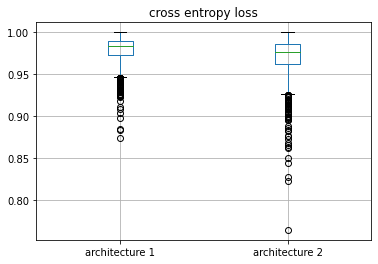

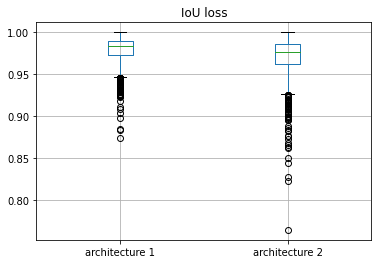

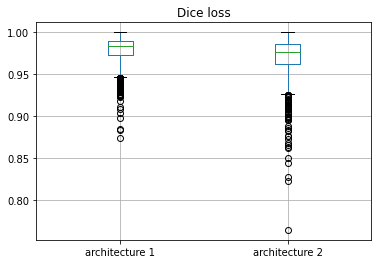

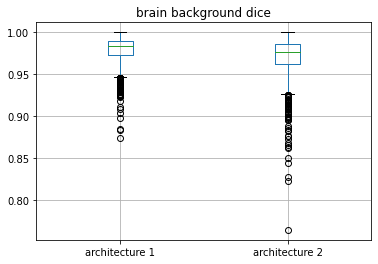

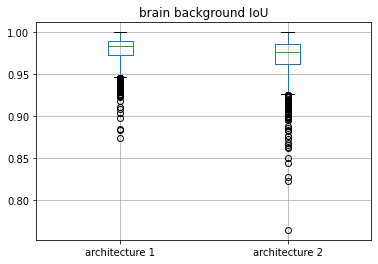

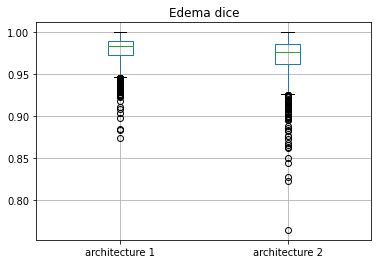

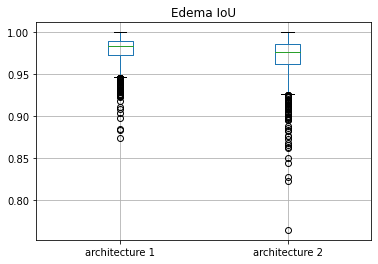

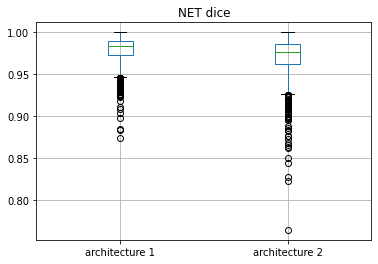

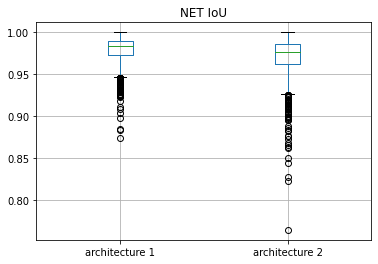

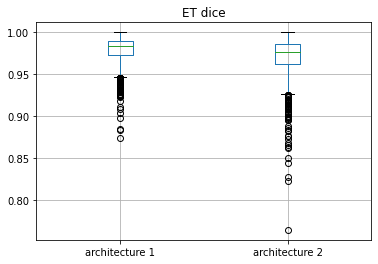

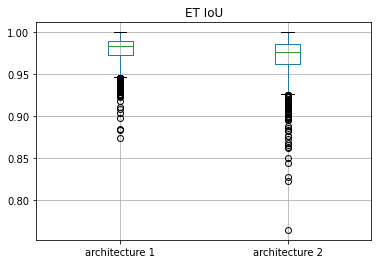

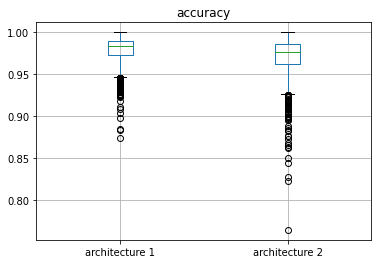

In [72]:
for col in ['cross entropy loss', 'IoU loss', 'Dice loss', 'brain background dice',
       'brain background IoU', 'Edema dice', 'Edema IoU', 'NET dice',
       'NET IoU', 'ET dice', 'ET IoU', 'accuracy']:
    
    pd.pivot_table(results_df, values='brain background dice', index='index',
                        columns=['architecture'], aggfunc=np.mean).boxplot()
    plt.title(col)
    plt.savefig('boxplots/' +col + '.jpg', dpi=300)
    plt.show()

In [80]:
results_df[results_df['architecture'] == 'architecture 1'].mean()

cross entropy loss         0.183224
IoU loss                   0.381362
Dice loss                  0.297934
brain background dice      0.978354
brain background IoU       0.958119
Edema dice                 0.748298
Edema IoU                  0.626164
NET dice                   0.518438
NET IoU                    0.437959
ET dice                    0.725006
ET IoU                     0.648396
accuracy                   0.957795
index                    532.500000
dtype: float64

In [81]:
results_df[results_df['architecture'] == 'architecture 1'].std()

cross entropy loss         0.097959
IoU loss                   0.166616
Dice loss                  0.166675
brain background dice      0.016464
brain background IoU       0.030654
Edema dice                 0.184220
Edema IoU                  0.196400
NET dice                   0.369878
NET IoU                    0.359001
ET dice                    0.321372
ET IoU                     0.322298
accuracy                   0.026417
index                    307.871997
dtype: float64

In [83]:
results_df[results_df['architecture'] == 'architecture 2'].mean()

cross entropy loss         0.139367
IoU loss                   0.294758
Dice loss                  0.231490
brain background dice      0.969666
brain background IoU       0.942150
Edema dice                 0.712482
Edema IoU                  0.582594
NET dice                   0.482447
NET IoU                    0.405451
ET dice                    0.679662
ET IoU                     0.599396
accuracy                   0.946099
index                    532.500000
dtype: float64

In [82]:
results_df[results_df['architecture'] == 'architecture 2'].std()

cross entropy loss         0.081381
IoU loss                   0.120217
Dice loss                  0.121639
brain background dice      0.024397
brain background IoU       0.043682
Edema dice                 0.191212
Edema IoU                  0.200168
NET dice                   0.375258
NET IoU                    0.360202
ET dice                    0.340014
ET IoU                     0.334460
accuracy                   0.033800
index                    307.871997
dtype: float64